<a href="https://colab.research.google.com/github/subhashpolisetti/Decision-Tree-Ensemble-Algorithms/blob/main/Decision_Tree_and_Random_Forest_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees and Random Forest from Scratch

This notebook demonstrates the implementation of decision trees and random forests from scratch in Python. The goal of this project is to understand the fundamental concepts behind these algorithms and how they work, step by step.

## Key Concepts

1. **Decision Tree**: A decision tree is a supervised learning algorithm used for classification and regression tasks. The tree splits the data based on feature thresholds to reduce impurity (using metrics like Gini impurity or Information Gain). The algorithm recursively builds the tree until a stopping condition is met.

2. **Random Forest**: Random Forest is an ensemble learning method that combines multiple decision trees to improve predictive performance and reduce overfitting. It works by training multiple trees on random subsets of the data and aggregating their predictions through majority voting (for classification) or averaging (for regression).

## Algorithm Details

### 1. **Decision Tree Algorithm**
   - **Gini Impurity**: A metric to measure the "impurity" of a node, which helps in deciding the best feature to split on.
   - **Splitting Data**: The dataset is split based on the feature value (threshold) that minimizes the Gini impurity.
   - **Recursive Tree Construction**: The tree recursively splits the data until stopping criteria such as maximum depth or minimum samples are met.

### 2. **Random Forest Algorithm**
   - **Bootstrap Sampling**: Random Forest uses bootstrap sampling (sampling with replacement) to create multiple datasets for training each decision tree.
   - **Majority Voting**: The predictions of all individual trees are combined through majority voting (for classification).
   - **Ensemble Learning**: Random Forest aggregates the predictions of multiple decision trees, which helps in reducing overfitting and improving generalization.

## Model Evaluation

The implementation is tested using the **Iris Dataset**:
   - The dataset is split into training and testing sets.
   - A Random Forest classifier is trained on the training set and tested on the test set.
   - The accuracy of the Random Forest model is evaluated using the `accuracy_score` metric.

## Feature Importance

The notebook also demonstrates how to calculate and visualize the feature importance in the Random Forest model. This is achieved by calculating how frequently each feature is used for splitting the data across all trees in the forest.

### Libraries Used
- `numpy`: For numerical computations and array manipulations.
- `collections.Counter`: To count occurrences of labels for prediction aggregation.
- `matplotlib`: For plotting the feature importance.

## Results

- The accuracy of the Random Forest model on the test set.
- A bar plot of feature importance based on the number of times each feature was used in the decision trees.

By the end of this notebook, you will have a better understanding of how decision trees and random forests work and how they can be implemented from scratch without relying on libraries like `sklearn`.

---

Feel free to explore and modify the code to experiment with different datasets and hyperparameters!


In [1]:

import numpy as np
from collections import Counter



In [2]:
def gini_impurity(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

In [3]:


def split_dataset(X, y, feature_index, threshold):
    left_indices = X[:, feature_index] <= threshold
    right_indices = X[:, feature_index] > threshold
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

In [4]:
def find_best_split(X, y):
    best_gini = float('inf')  # Initialize the best Gini impurity as infinity (worst possible case)
    best_split = None  # Variable to store the best split (feature and threshold)
    n_features = X.shape[1]  # Get the number of features in the dataset

    # Iterate over each feature to find the best feature for splitting
    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])  # Get all unique values for the current feature
        # Iterate over all possible threshold values for the feature
        for threshold in thresholds:
            # Split the dataset into left and right based on the threshold for this feature
            _, _, y_left, y_right = split_dataset(X, y, feature_index, threshold)

            # Skip this split if it results in empty subsets (i.e., no data in left or right split)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            # Calculate the Gini impurity for the split (weighted by the size of the subsets)
            gini = (len(y_left) / len(y) * gini_impurity(y_left) +  # Gini impurity for left split
                    len(y_right) / len(y) * gini_impurity(y_right))  # Gini impurity for right split

            # If the current split has a lower Gini impurity, update the best split
            if gini < best_gini:
                best_gini = gini  # Update the best Gini impurity
                best_split = (feature_index, threshold)  # Store the current best split (feature and threshold)

    return best_split  # Return the feature index and threshold that gave the best split


In [5]:
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth  # Maximum depth of the tree to control overfitting
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split a node
        self.tree = None  # The tree will be built during the training phase (fit)

    def fit(self, X, y, depth=0):
        # Stopping criteria:
        # 1. If max depth is reached.
        # 2. If there are not enough samples to split.
        # 3. If the data at this node belongs to only one class (pure node).
        if depth == self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1:
            return Counter(y).most_common(1)[0][0]  # Return the most common class (leaf node)

        # Find the best feature and threshold to split the data
        feature_index, threshold = find_best_split(X, y)

        # If no valid split is found (all features failed), return the most common class
        if feature_index is None:
            return Counter(y).most_common(1)[0][0]

        # Split the dataset based on the best feature and threshold
        left_X, right_X, left_y, right_y = split_dataset(X, y, feature_index, threshold)

        # Recursively build the left and right subtrees
        self.tree = {
            "feature_index": feature_index,  # Index of the feature used for splitting
            "threshold": threshold,  # Threshold used for splitting
            "left": self.fit(left_X, left_y, depth + 1),  # Recursively fit left subtree
            "right": self.fit(right_X, right_y, depth + 1)  # Recursively fit right subtree
        }
        return self.tree  # Return the root of the tree

    def predict_single(self, x, tree):
        # Recursive function to traverse the tree and predict a single instance
        if isinstance(tree, dict):  # If the current node is not a leaf
            # If the feature value at the node is less than or equal to the threshold, go left; else go right
            if x[tree["feature_index"]] <= tree["threshold"]:
                return self.predict_single(x, tree["left"])
            else:
                return self.predict_single(x, tree["right"])
        return tree  # Return the predicted class (leaf node)

    def predict(self, X):
        # Predict for all instances in the dataset
        return np.array([self.predict_single(x, self.tree) for x in X])


In [6]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2):
        self.n_trees = n_trees  # Number of trees in the forest
        self.max_depth = max_depth  # Maximum depth for each decision tree to prevent overfitting
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split a node
        self.trees = []  # List to hold the individual decision trees

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]  # Get the total number of samples in the dataset
        indices = np.random.choice(n_samples, n_samples, replace=True)  # Randomly select samples with replacement
        return X[indices], y[indices]  # Return the bootstrapped sample (with replacement)

    def fit(self, X, y):
        self.trees = []  # Reset the list of trees before training
        # Train multiple decision trees
        for _ in range(self.n_trees):
            X_sample, y_sample = self.bootstrap_sample(X, y)  # Get a bootstrapped sample of the data
            tree = DecisionTree(self.max_depth, self.min_samples_split)  # Create a new decision tree
            tree.fit(X_sample, y_sample)  # Train the tree on the bootstrapped sample
            self.trees.append(tree)  # Add the trained tree to the forest

    def predict(self, X):
        # Get predictions from each tree in the forest
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        # Perform majority voting to determine the final prediction for each instance
        return np.array([Counter(tree_predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])])


In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
forest = RandomForest(n_trees=10, max_depth=5)
forest.fit(X_train, y_train)

# Test Random Forest
predictions = forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))


Accuracy: 1.0


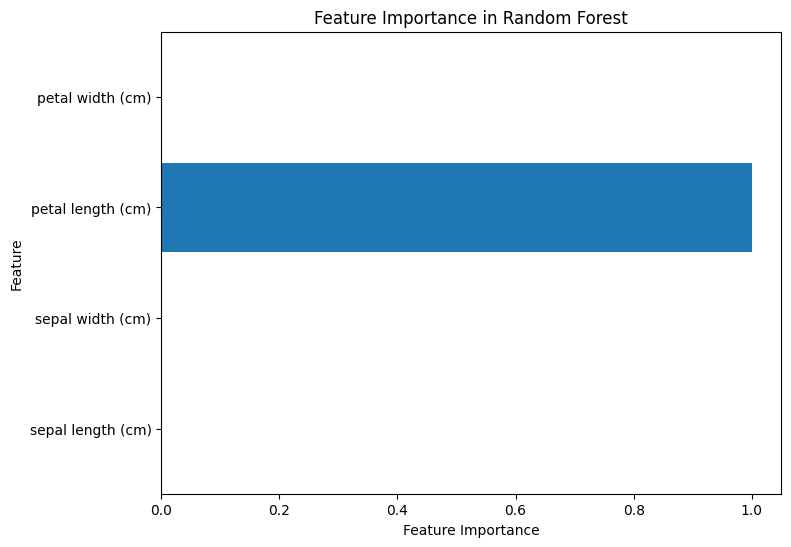

In [8]:
import matplotlib.pyplot as plt

def plot_feature_importance(forest, feature_names):
    # Initialize an array to store the importance of each feature
    importances = np.zeros(len(feature_names))

    # Loop through each tree in the random forest
    for tree in forest.trees:
        # If the tree is a valid decision tree (i.e., it has been trained)
        if isinstance(tree.tree, dict):
            # Increment the importance for the feature that was used to split at this node
            importances[tree.tree["feature_index"]] += 1

    # Normalize the importance values by dividing by the total number of splits to get a proportion
    importances = importances / sum(importances)

    # Create a horizontal bar plot to display feature importance
    plt.figure(figsize=(8, 6))  # Set the figure size for the plot
    plt.barh(range(len(importances)), importances, align='center')  # Bar plot for feature importances
    plt.yticks(range(len(feature_names)), feature_names)  # Label the y-axis with the feature names
    plt.xlabel("Feature Importance")  # Label for the x-axis
    plt.ylabel("Feature")  # Label for the y-axis
    plt.title("Feature Importance in Random Forest")  # Title of the plot
    plt.show()  # Display the plot

# Call the function to visualize feature importance
plot_feature_importance(forest, data.feature_names)
